# `merge_replicates.ipynb`
Author: **Sam Morabito**

The goal of this notebook is to merge all the replicates/samples for the SERPENTINE project into a single *anndata* project to facilitate an integrated downstream analysis.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import harmonypy as hm
import anndata
import os
import scrublet
sc.settings.set_figure_params(dpi=500, dpi_save=1000, figsize=(5,5), facecolor='white')

In [2]:
# set up the data directory
counts_dir = "/home/groups/singlecell/smorabito/shared/SERPENTINE/data/"



In [3]:
os.chdir('/home/groups/singlecell/smorabito/analysis/SERPENTINE/')
data_dir = 'data/'
fig_dir = 'figures/'


In [4]:
# loading the metadata table
meta_table = pd.read_csv(
    "/home/groups/singlecell/smorabito/analysis/SERPENTINE/data/SERPENTINE_metadata.txt", 
    sep='\t',
    encoding = 'utf-16'
)



In [5]:
meta_table.head()

Subproject_CNAG                    ID_CNAG     Tissue Libraries  Sample  \
0  SERPENTINE_04_05       SPE_1_01_SCR_A_FRESH  Liver met  GEX, TCR       1   
1  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH_CD45  Liver met  GEX, TCR       1   
2  SERPENTINE_06_07     SPE_1_02_SCR_A_FRESH_1  Liver met  GEX, TCR       2   
3  SERPENTINE_06_07     SPE_1_02_SCR_A_FRESH_2  Liver met  GEX, TCR       2   
4  SERPENTINE_08_09    SPE_1_01_C2D1_A_FRESH_1  Liver met  GEX, TCR       1   

   Timepoint            Info           Fractions loaded biopsy_id  \
0          1  ID is 01_total  total (no FACS selection)    23-585   
1          1   ID is 01_CD45                  100%CD45+    23-585   
2          1             NaN          40%CD45+/60%CD45-   23-2888   
3          1             NaN          40%CD45+/60%CD45-   23-2888   
4          2             NaN          20%CD45+/80%CD45-   23-4301   

   localizacion_SNOMED Timepoint_1  
0  T56000 - HIGADO, NE   SCREENING  
1  T56000 - HIGADO, NE   SCREENING  
2  T56000 - HIGADO, NE   SCREENING  
3  T56000 - HIGADO, NE   SCREENING  
4  T56000 - HIGADO, NE          C2

In [13]:
meta_table.shape[0]
meta_table.iloc[2]['Subproject_CNAG']

i = 0 

adata_list = []


for cur_subproject in meta_table['Subproject_CNAG'].unique():
    
    print(cur_subproject)
    
    # for this subproject, get the different reps that we sequenced (ie CD45+/- or total)
    if os.path.exists('{}{}/jobs/'.format(counts_dir, cur_subproject)):
        cur_reps = os.listdir('/home/groups/singlecell/smorabito/shared/SERPENTINE/data/{}/jobs/'.format(cur_subproject))
    else:
        cur_reps = os.listdir('/home/groups/singlecell/smorabito/shared/SERPENTINE/data/{}/jobs_human/'.format(cur_subproject))

    # loop over each replicate for this subproject, and load the gene expression counts matrices
    cur_adata_list = []
    for x in cur_reps:
        if os.path.exists('{}{}/jobs/'.format(counts_dir, cur_subproject)):
            cur_cellranger_dir = "{}{}/jobs/{}/{}/outs/per_sample_outs/{}/count/sample_filtered_feature_bc_matrix/".format(counts_dir, cur_subproject, x, x, x)
        else:
            cur_cellranger_dir = "{}{}/jobs_human/{}/{}/outs/per_sample_outs/{}/count/sample_filtered_feature_bc_matrix/".format(counts_dir, cur_subproject, x, x, x)
        try:
            cur_adata = sc.read_10x_mtx(cur_cellranger_dir)
        except:
            print('Issue loading {}, skipping for now.'.format(x))
            continue
        cur_adata.obs['Subproject_CNAG'] = cur_subproject 
        cur_adata.obs['Replicate'] = x

        # add patient label:
        tmp = x.split('_')
        if len(tmp) > 2:
            cur_patient = tmp[2]
            if len(cur_patient) == 1:
                cur_patient = '0' + cur_patient
        else:
            cur_patient = tmp[0]
        cur_patient = 'Patient ' + cur_patient
        print(cur_patient)
        cur_adata.obs['Patient'] = cur_patient
        cur_adata.obs['bc'] = [bc.split('-')[0] for bc in cur_adata.obs.index.to_list()]
        cur_adata_list.append(cur_adata)
        print(cur_adata.shape)

    adata_list = adata_list + cur_adata_list

        



SERPENTINE_04_05
Patient 01
(694, 36601)
Patient 01
(4682, 36601)
SERPENTINE_06_07
Patient 02
(8351, 36601)
Patient 02
(6858, 36601)
SERPENTINE_08_09
Patient 01
(4470, 36601)
Patient 01
(4011, 36601)
SERPENTINE_10_11
Patient 02
(6693, 36601)
Patient 03
(1110, 36601)
Patient 02
(5798, 36601)
SERPENTINE_12_13
Patient 04
(11125, 36601)
Patient 04
(11551, 36601)
SERPENTINE_14_15
Patient 03
(3815, 36601)
SERPENTINE_16_17
Patient 04
(6516, 36601)
Patient 04
(5440, 36601)
SERPENTINE_18_19
Patient 03
(1451, 36601)
Patient 03
(8306, 36601)
SERPENTINE_20_21
Patient 05
(5481, 36601)
Patient 06
(1042, 36601)
Patient 06
(3623, 36601)
SERPENTINE_22_23
Patient 08
(15757, 36601)
SERPENTINE_24_25
Patient 09
(7434, 36601)
SERPENTINE_26_27
Patient 07
(3333, 36601)
Patient 07
(160, 36601)
SERPENTINE_28_29
Patient 10
(6935, 36601)
Patient 10
(15640, 36601)
SERPENTINE_30_31
Patient 08
(6484, 36601)
Patient 08
(6995, 36601)
SERPENTINE_32_33
Patient 09
(8119, 36601)
Patient 09
(7793, 36601)
SERPENTINE_34_35
P

In [33]:
adata.obs.Replicate.unique()

array(['01_total', '01_CD45', 'SPE_1_02_SCR_A_FRESH_1',
       'SPE_1_02_SCR_A_FRESH_2', 'SPE_1_01_C2D1_A_FRESH_1',
       'SPE_1_01_C2D1_A_FRESH_2', 'SPE_1_02_C02_A_FRESH_1',
       'SPE_1_03_SCR_A_FRESH', 'SPE_1_02_C02_A_FRESH_2',
       'SPE_1_04_SCR_A_FRESH_2', 'SPE_1_04_SCR_A_FRESH_1',
       'SPE_1_03_C02_A_FRESH_C45', 'SPE_1_04_C02_A_FRESH_1',
       'SPE_1_04_C02_A_FRESH_2', 'ESP_1_03_EOT_A_FRESH_CD45neg',
       'ESP_1_03_EOT_A_FRESH_CD45pos', 'SPE_1_05_SCR_A_FRESH',
       'SPE_1_06_SCR_A_FRESH_CD45neg', 'SPE_1_06_SCR_A_FRESH_CD45pos',
       'SPE_1_08_SCR_A_FRESH', 'SPE_1_09_SCR_A_FRESH',
       'ESP_1_07_SCR_A_FRESH_CD45pos', 'ESP_1_07_SCR_A_FRESH_CD45neg',
       'SPE_1_10_SCR_A_FRESH_CD45neg', 'SPE_1_10_SCR_A_FRESH_CD45pos',
       'SPE_1_8_C2_A_FRESH_2', 'SPE_1_8_C2_A_FRESH_1',
       'SPE_1_09_C2_A_FRESH_CD45neg', 'SPE_1_09_C2_A_FRESH_CD45pos',
       'SPE_1_07_C2_A_FRESH_1', 'SPE_1_07_C2_A_FRESH_2',
       'SPE_1_10_C2_A_FRESH_CD45pos', 'SPE_1_10_C2_A_FRESH_CD45neg',
 

In [14]:
# concatenate into a single adata:
adata = adata_list[0].concatenate(adata_list[1:])

/scratch_tmp/21626219/ipykernel_135205/3640988106.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_list[0].concatenate(adata_list[1:])


In [ ]:
rep = adata.obs.Replicate.replace({'01_total':'SPE_1_01_SCR_A_FRESH', '01_CD45':'SPE_1_01_SCR_A_FRESH_CD45'})
adata.obs.Replicate = rep

In [15]:
adata.shape

(251411, 36601)

### Add patient-level metadata to the `anndata` object

In [16]:
# loading the metadata table
patient_meta_table = pd.read_csv(
    "/home/groups/singlecell/smorabito/analysis/SERPENTINE/data/SERPENTINE_metadata_patient.txt",
    sep='\t',
    encoding = 'utf-16'
)
patient_meta_table.head()


Patient      DOB   Tumor Type Primary tumor               Histology  \
0  Patient 01  15APR71          CRC        Rectum          Adenocarcinoma   
1  Patient 02  25MAY70          CRC        Rectum          Adenocarcinoma   
2  Patient 03   9SEP61          CRC   Right colon          Adenocarcinoma   
3  Patient 04   7DEC68  Endometrial   Endometrial  Endometrioid carcinoma   
4  Patient 05   4SEP74          CRC       Sigmoid          Adenocarcinoma   

  Microsatellite status               Molecular profile  N pre lines  \
0                   MSS                       KRAS G13D          5.0   
1                   MSS                       KRAS G12S          2.0   
2                   MSS                       KRAS G13D          3.0   
3                   MSI  MLH1 hypermet, p53 wt, POLE wt          1.0   
4                   MSS                       KRAS G12V          3.0   

                                  Previous therapies  \
0  FOLFOX, FOLFOXIRI + Bev, FOLFIRI, FOLFIRI + Pa...   
1                FOLFOX + Bev, FOLFIRI + Aflibercept   
2       FOLFOX + Bev, FOLFOXIRI + Bev, FOLFIRI + Bev   
3                           Carboplatin + Paclitaxel   
4                      FOLFOX, FOLFIRI + Bev, TAS102   

                                 Metastases location    Cohort  \
0  Liver, lung, adrenal, bone, peritoneum, lymph ...   2 (MSS)   
1                           Liver, lung, lymph nodes   2 (MSS)   
2                               Liver, lung, adrenal   2 (MSS)   
3                                       Lung, pelvic  1A (MSI)   
4                                  Liver, peritoneum   2 (MSS)   

                   Treatment Biopsy pre-treat Biopsy pre-C2 Biopsy BiopsyEOT  \
0  Durvalumab + Tremelimumab          10/1/23        7/2/23                    
1  Durvalumab + Tremelimumab           1/2/23       20/3/23                    
2  Durvalumab + Tremelimumab          20/3/23       17/4/23                    
3                Durvalumab            3/4/23        2/5/23          23/5/23   
4  Durvalumab + Tremelimumab          26/6/23                                  

         Best response  
0  Progression disease  
1  Progression disease  
2  Progression disease  
3  Progression disease  
4    Screening failure

In [17]:
adata.obs['barcode'] = adata.obs.index.to_list()

# merge with anndata obs
temp = adata.obs.merge(patient_meta_table, how='left', on='Patient')
temp.index = temp.barcode
adata.obs = temp

In [31]:
adata.obs.head()

Subproject_CNAG Replicate     Patient  \
barcode                                                        
AAACCTGAGGAACTGC-1-0  SERPENTINE_04_05  01_total  Patient 01   
AAACCTGGTCAAAGAT-1-0  SERPENTINE_04_05  01_total  Patient 01   
AAAGATGAGTACGACG-1-0  SERPENTINE_04_05  01_total  Patient 01   
AAAGATGCAGACGCAA-1-0  SERPENTINE_04_05  01_total  Patient 01   
AAATGCCTCATCATTC-1-0  SERPENTINE_04_05  01_total  Patient 01   

                                    bc batch               barcode      DOB  \
barcode                                                                       
AAACCTGAGGAACTGC-1-0  AAACCTGAGGAACTGC     0  AAACCTGAGGAACTGC-1-0  15APR71   
AAACCTGGTCAAAGAT-1-0  AAACCTGGTCAAAGAT     0  AAACCTGGTCAAAGAT-1-0  15APR71   
AAAGATGAGTACGACG-1-0  AAAGATGAGTACGACG     0  AAAGATGAGTACGACG-1-0  15APR71   
AAAGATGCAGACGCAA-1-0  AAAGATGCAGACGCAA     0  AAAGATGCAGACGCAA-1-0  15APR71   
AAATGCCTCATCATTC-1-0  AAATGCCTCATCATTC     0  AAATGCCTCATCATTC-1-0  15APR71   

                     Tumor Type Primary tumor       Histology  ...  \
barcode                                                        ...   
AAACCTGAGGAACTGC-1-0        CRC        Rectum  Adenocarcinoma  ...   
AAACCTGGTCAAAGAT-1-0        CRC        Rectum  Adenocarcinoma  ...   
AAAGATGAGTACGACG-1-0        CRC        Rectum  Adenocarcinoma  ...   
AAAGATGCAGACGCAA-1-0        CRC        Rectum  Adenocarcinoma  ...   
AAATGCCTCATCATTC-1-0        CRC        Rectum  Adenocarcinoma  ...   

                     N pre lines  \
barcode                            
AAACCTGAGGAACTGC-1-0         5.0   
AAACCTGGTCAAAGAT-1-0         5.0   
AAAGATGAGTACGACG-1-0         5.0   
AAAGATGCAGACGCAA-1-0         5.0   
AAATGCCTCATCATTC-1-0         5.0   

                                                     Previous therapies  \
barcode                                                                   
AAACCTGAGGAACTGC-1-0  FOLFOX, FOLFOXIRI + Bev, FOLFIRI, FOLFIRI + Pa...   
AAACCTGGTCAAAGAT-1-0  FOLFOX, FOLFOXIRI + Bev, FOLFIRI, FOLFIRI + Pa...   
AAAGATGAGTACGACG-1-0  FOLFOX, FOLFOXIRI + Bev, FOLFIRI, FOLFIRI + Pa...   
AAAGATGCAGACGCAA-1-0  FOLFOX, FOLFOXIRI + Bev, FOLFIRI, FOLFIRI + Pa...   
AAATGCCTCATCATTC-1-0  FOLFOX, FOLFOXIRI + Bev, FOLFIRI, FOLFIRI + Pa...   

                                                    Metastases location  \
barcode                                                                   
AAACCTGAGGAACTGC-1-0  Liver, lung, adrenal, bone, peritoneum, lymph ...   
AAACCTGGTCAAAGAT-1-0  Liver, lung, adrenal, bone, peritoneum, lymph ...   
AAAGATGAGTACGACG-1-0  Liver, lung, adrenal, bone, peritoneum, lymph ...   
AAAGATGCAGACGCAA-1-0  Liver, lung, adrenal, bone, peritoneum, lymph ...   
AAATGCCTCATCATTC-1-0  Liver, lung, adrenal, bone, peritoneum, lymph ...   

                        Cohort                  Treatment Biopsy pre-treat  \
barcode                                                                      
AAACCTGAGGAACTGC-1-0   2 (MSS)  Durvalumab + Tremelimumab          10/1/23   
AAACCTGGTCAAAGAT-1-0   2 (MSS)  Durvalumab + Tremelimumab          10/1/23   
AAAGATGAGTACGACG-1-0   2 (MSS)  Durvalumab + Tremelimumab          10/1/23   
AAAGATGCAGACGCAA-1-0   2 (MSS)  Durvalumab + Tremelimumab          10/1/23   
AAATGCCTCATCATTC-1-0   2 (MSS)  Durvalumab + Tremelimumab          10/1/23   

                     Biopsy pre-C2 Biopsy BiopsyEOT        Best response  
barcode                                                                   
AAACCTGAGGAACTGC-1-0        7/2/23                   Progression disease  
AAACCTGGTCAAAGAT-1-0        7/2/23                   Progression disease  
AAAGATGAGTACGACG-1-0        7/2/23                   Progression disease  
AAAGATGCAGACGCAA-1-0        7/2/23                   Progression disease  
AAATGCCTCATCATTC-1-0        7/2/23                   Progression disease  

[5 rows x 22 columns]

### Add project-level meta-ata to the `anndata` object

TODO!!!

In [19]:
# loading the metadata table
project_meta_table = pd.read_csv(
    "/home/groups/singlecell/smorabito/analysis/SERPENTINE/data/SERPENTINE_metadata.txt",
    sep='\t',
    encoding = 'utf-16'
)
project_meta_table.head()


Subproject_CNAG                    ID_CNAG     Tissue Libraries  Sample  \
0  SERPENTINE_04_05       SPE_1_01_SCR_A_FRESH  Liver met  GEX, TCR       1   
1  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH_CD45  Liver met  GEX, TCR       1   
2  SERPENTINE_06_07     SPE_1_02_SCR_A_FRESH_1  Liver met  GEX, TCR       2   
3  SERPENTINE_06_07     SPE_1_02_SCR_A_FRESH_2  Liver met  GEX, TCR       2   
4  SERPENTINE_08_09    SPE_1_01_C2D1_A_FRESH_1  Liver met  GEX, TCR       1   

   Timepoint            Info           Fractions loaded biopsy_id  \
0          1  ID is 01_total  total (no FACS selection)    23-585   
1          1   ID is 01_CD45                  100%CD45+    23-585   
2          1             NaN          40%CD45+/60%CD45-   23-2888   
3          1             NaN          40%CD45+/60%CD45-   23-2888   
4          2             NaN          20%CD45+/80%CD45-   23-4301   

   localizacion_SNOMED Timepoint_1  
0  T56000 - HIGADO, NE   SCREENING  
1  T56000 - HIGADO, NE   SCREENING  
2  T56000 - HIGADO, NE   SCREENING  
3  T56000 - HIGADO, NE   SCREENING  
4  T56000 - HIGADO, NE          C2

In [40]:
# merge with anndata obs
temp = adata.obs.merge(project_meta_table, how='left', left_on='Replicate', right_on='ID_CNAG')
temp.index = temp.barcode
adata.obs = temp


In [41]:
adata.obs.head()

Subproject_CNAG_x             Replicate     Patient  \
barcode                                                                    
AAACCTGAGGAACTGC-1-0  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01   
AAACCTGGTCAAAGAT-1-0  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01   
AAAGATGAGTACGACG-1-0  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01   
AAAGATGCAGACGCAA-1-0  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01   
AAATGCCTCATCATTC-1-0  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01   

                                    bc batch               barcode      DOB  \
barcode                                                                       
AAACCTGAGGAACTGC-1-0  AAACCTGAGGAACTGC     0  AAACCTGAGGAACTGC-1-0  15APR71   
AAACCTGGTCAAAGAT-1-0  AAACCTGGTCAAAGAT     0  AAACCTGGTCAAAGAT-1-0  15APR71   
AAAGATGAGTACGACG-1-0  AAAGATGAGTACGACG     0  AAAGATGAGTACGACG-1-0  15APR71   
AAAGATGCAGACGCAA-1-0  AAAGATGCAGACGCAA     0  AAAGATGCAGACGCAA-1-0  15APR71   
AAATGCCTCATCATTC-1-0  AAATGCCTCATCATTC     0  AAATGCCTCATCATTC-1-0  15APR71   

                     Tumor Type Primary tumor       Histology  ...  \
barcode                                                        ...   
AAACCTGAGGAACTGC-1-0        CRC        Rectum  Adenocarcinoma  ...   
AAACCTGGTCAAAGAT-1-0        CRC        Rectum  Adenocarcinoma  ...   
AAAGATGAGTACGACG-1-0        CRC        Rectum  Adenocarcinoma  ...   
AAAGATGCAGACGCAA-1-0        CRC        Rectum  Adenocarcinoma  ...   
AAATGCCTCATCATTC-1-0        CRC        Rectum  Adenocarcinoma  ...   

                                   ID_CNAG     Tissue  Libraries Sample  \
barcode                                                                   
AAACCTGAGGAACTGC-1-0  SPE_1_01_SCR_A_FRESH  Liver met   GEX, TCR    1.0   
AAACCTGGTCAAAGAT-1-0  SPE_1_01_SCR_A_FRESH  Liver met   GEX, TCR    1.0   
AAAGATGAGTACGACG-1-0  SPE_1_01_SCR_A_FRESH  Liver met   GEX, TCR    1.0   
AAAGATGCAGACGCAA-1-0  SPE_1_01_SCR_A_FRESH  Liver met   GEX, TCR    1.0   
AAATGCCTCATCATTC-1-0  SPE_1_01_SCR_A_FRESH  Liver met   GEX, TCR    1.0   

                     Timepoint            Info           Fractions loaded  \
barcode                                                                     
AAACCTGAGGAACTGC-1-0       1.0  ID is 01_total  total (no FACS selection)   
AAACCTGGTCAAAGAT-1-0       1.0  ID is 01_total  total (no FACS selection)   
AAAGATGAGTACGACG-1-0       1.0  ID is 01_total  total (no FACS selection)   
AAAGATGCAGACGCAA-1-0       1.0  ID is 01_total  total (no FACS selection)   
AAATGCCTCATCATTC-1-0       1.0  ID is 01_total  total (no FACS selection)   

                     biopsy_id  localizacion_SNOMED Timepoint_1  
barcode                                                          
AAACCTGAGGAACTGC-1-0    23-585  T56000 - HIGADO, NE   SCREENING  
AAACCTGGTCAAAGAT-1-0    23-585  T56000 - HIGADO, NE   SCREENING  
AAAGATGAGTACGACG-1-0    23-585  T56000 - HIGADO, NE   SCREENING  
AAAGATGCAGACGCAA-1-0    23-585  T56000 - HIGADO, NE   SCREENING  
AAATGCCTCATCATTC-1-0    23-585  T56000 - HIGADO, NE   SCREENING  

[5 rows x 33 columns]

## Doublet detection

Here we loop over each replicate and run `Scrublet` with default settings to get a "doublet score" for each cell. This score gives us an idea of some barcodes in our dataset that may be attributable to more than one cell in a given 10X droplet. These are typically removed from downstream analysis after detection.

In [42]:
import scrublet as scr

In [51]:
# get a list of all the samples in our adata
samples = adata.obs.Replicate.unique()
obs_list = []

# loop through each sample and run Scrublet
for cur_sample in samples:
    print(cur_sample)
    cur_adata = adata[adata.obs.Replicate == cur_sample].copy()
    print(cur_adata.shape)
    if cur_adata.shape[0] < 500:
        cur_adata.obs['doublet_score'] = 0
        cur_adata.obs['predicted_doublet'] = True
    else:  
        scrub = scr.Scrublet(cur_adata.X)
        doublet_scores, predicted_doublets = scrub.scrub_doublets()
        cur_adata.obs['doublet_score'] = doublet_scores 
        cur_adata.obs['predicted_doublet'] = predicted_doublets
    obs_list.append(cur_adata.obs)

# concatenate the resutls into one table
doublet_df  = pd.concat(obs_list)
doublet_df = doublet_df.set_index('barcode')
adata.obs = adata.obs.set_index('barcode')

# merge with the doublet_df
temp = adata.obs.merge(
    doublet_df,
    on = 'barcode'
)
adata.obs['doublet_score'] = temp['doublet_score']
adata.obs['predicted_doublet'] = temp['predicted_doublet']
adata.obs['predicted_doublet'] = adata.obs['predicted_doublet'].astype("category")

SPE_1_01_SCR_A_FRESH
(694, 36601)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.46
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 10.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 0.4 seconds
SPE_1_01_SCR_A_FRESH_CD45
(4682, 36601)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.2%
Elapsed time: 4.1 seconds
SPE_1_02_SCR_A_FRESH_1
(8351, 36601)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 20.9%
Overall dou

/home/groups/singlecell/smorabito/.conda/envs/serp-scanpy/lib/python3.11/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


ValueError: Found array with 0 feature(s) (shape=(2463, 0)) while a minimum of 1 is required by PCA.

## Inspect cell-level quality control (QC) metrics 

In [52]:
# compute QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [ ]:
sc.settings.set_figure_params(dpi=400, dpi_save=400, figsize=(10,4), facecolor='white')
sc.pl.violin(adata,[ 'total_counts'], inner='box', size=0,  groupby='Replicate', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'n_genes_by_counts'], inner='box', size=0,  groupby='Replicate', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'pct_counts_mt'], inner='box', size=0,  groupby='Replicate', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'doublet_score'], inner='box', size=0,  groupby='Replicate', multi_panel=False, rotation=90)

## Save the unprocessed `anndata` object

In [ ]:
adata.write('{}SERPENTINE_merged_unprocessed_090424.h5ad'.format(data_dir))

## First pass clustering analysis 

Here we use `Scanpy` to perform a first-pass clustering analysis, without any additional QC filtering or any fancy methods.

In [66]:
# load the unprocessed dataset
adata = sc.read('{}SERPENTINE_merged_unprocessed_090424.h5ad'.format(data_dir))

# save the counts layer
adata.layers['counts'] = adata.X 


In [67]:
# normalize
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# retain the "Raw" adata object for later
adata.raw = adata

In [70]:
# identify HVGs
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000
)

In [71]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

In [72]:
sc.pp.neighbors(adata, use_rep = 'X_pca', n_neighbors=20, n_pcs=30, metric='cosine')


/home/groups/singlecell/smorabito/.conda/envs/serp-scanpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [73]:
sc.tl.umap(adata, min_dist=0.35, method='umap')

In [74]:
# clustering 
sc.tl.leiden(adata, resolution=2)
sc.tl.dendrogram(adata, 'leiden')

/scratch_tmp/21445267/ipykernel_156545/369893914.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=2)


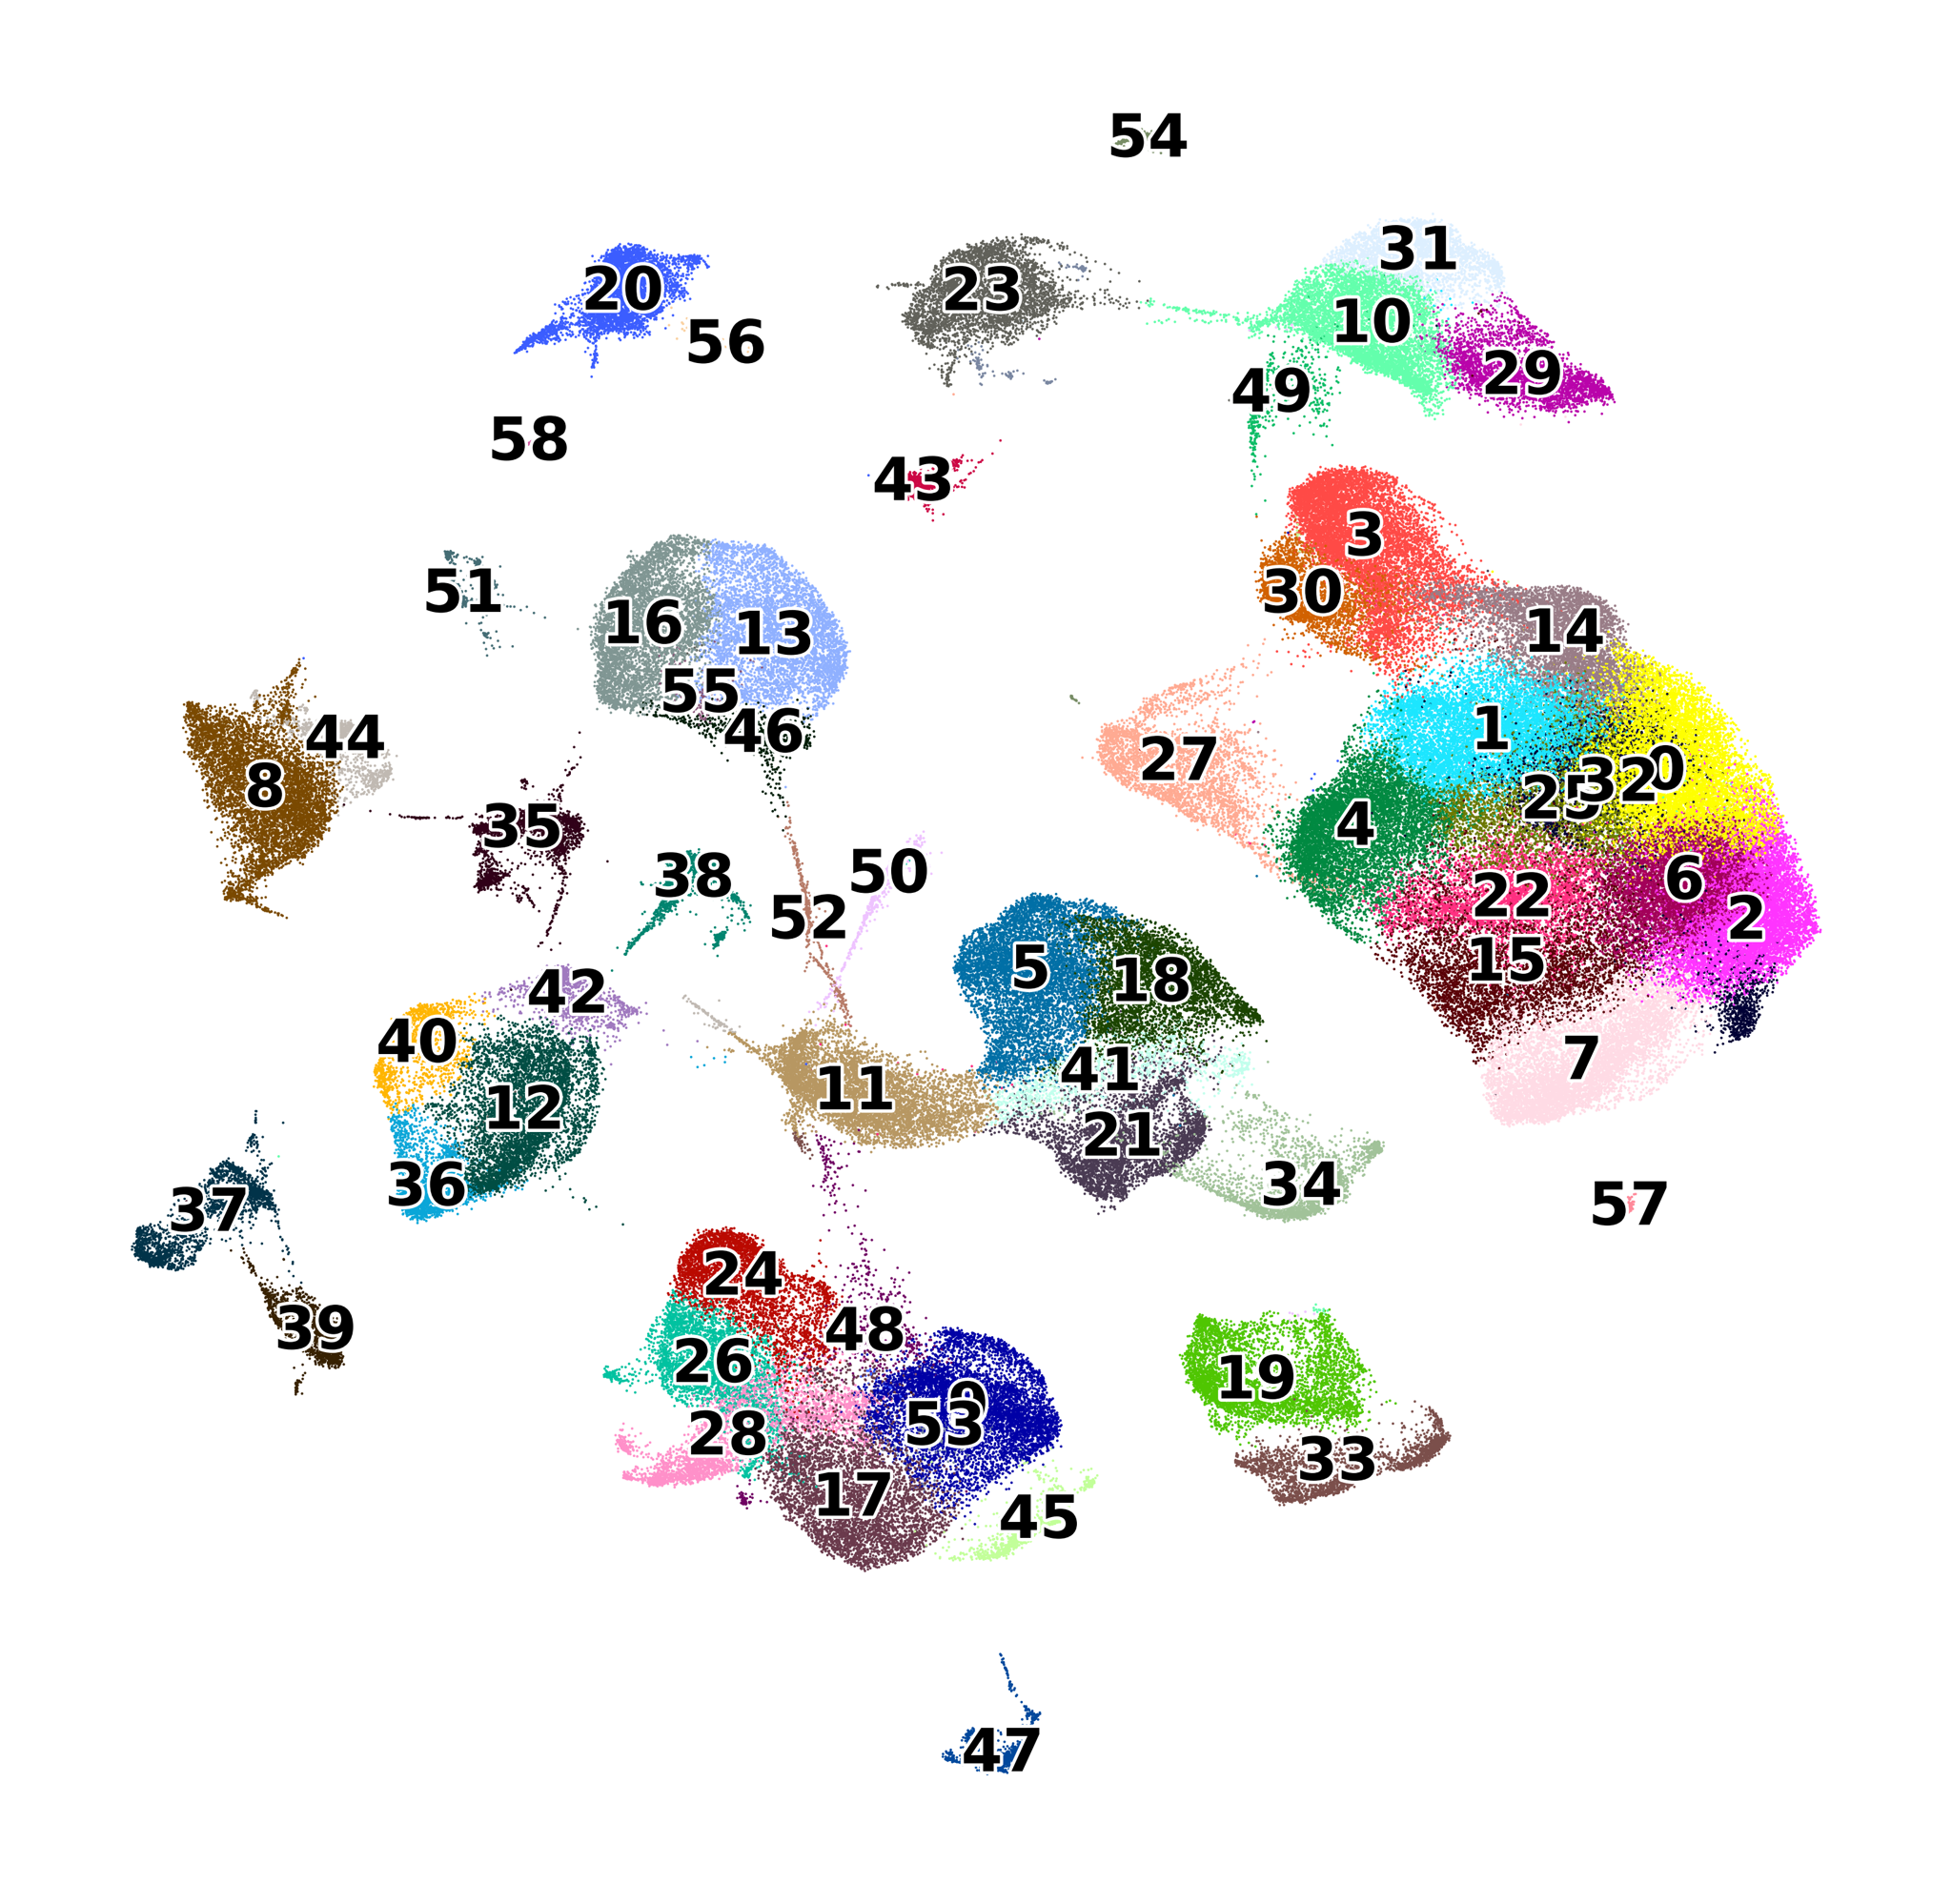

In [75]:
sc.settings.set_figure_params(dpi=400, dpi_save=500, figsize=(5,5), facecolor='white')
sc.pl.umap(
    adata, 
    color=['leiden'],
    frameon=False, 
    legend_loc='on data', 
    legend_fontoutline=1, 
    legend_fontsize=9, 
    title='',
    save='_leiden.pdf'
)

KeyError: 'Tissue'

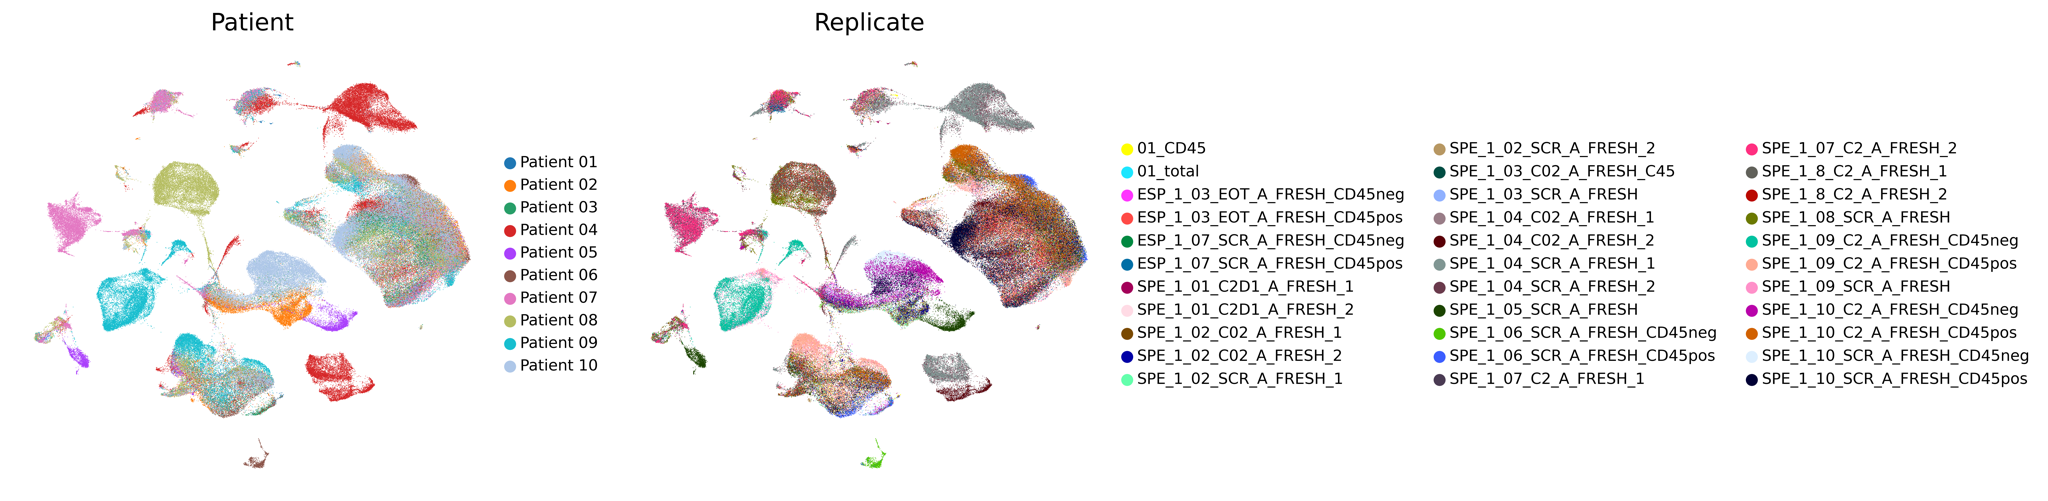

In [89]:
sc.settings.set_figure_params(dpi=400, dpi_save=500, figsize=(5,5), facecolor='white')
sc.pl.umap(
    adata, 
    color=['Patient', 'Replicate', 'Tissue', 'Timepoint'],
    frameon=False, 
    #legend_loc='on data', 
    legend_fontoutline=1, 
    legend_fontsize=9, 
    ncols=2,
    #title='',
    save='_patients.pdf'
)

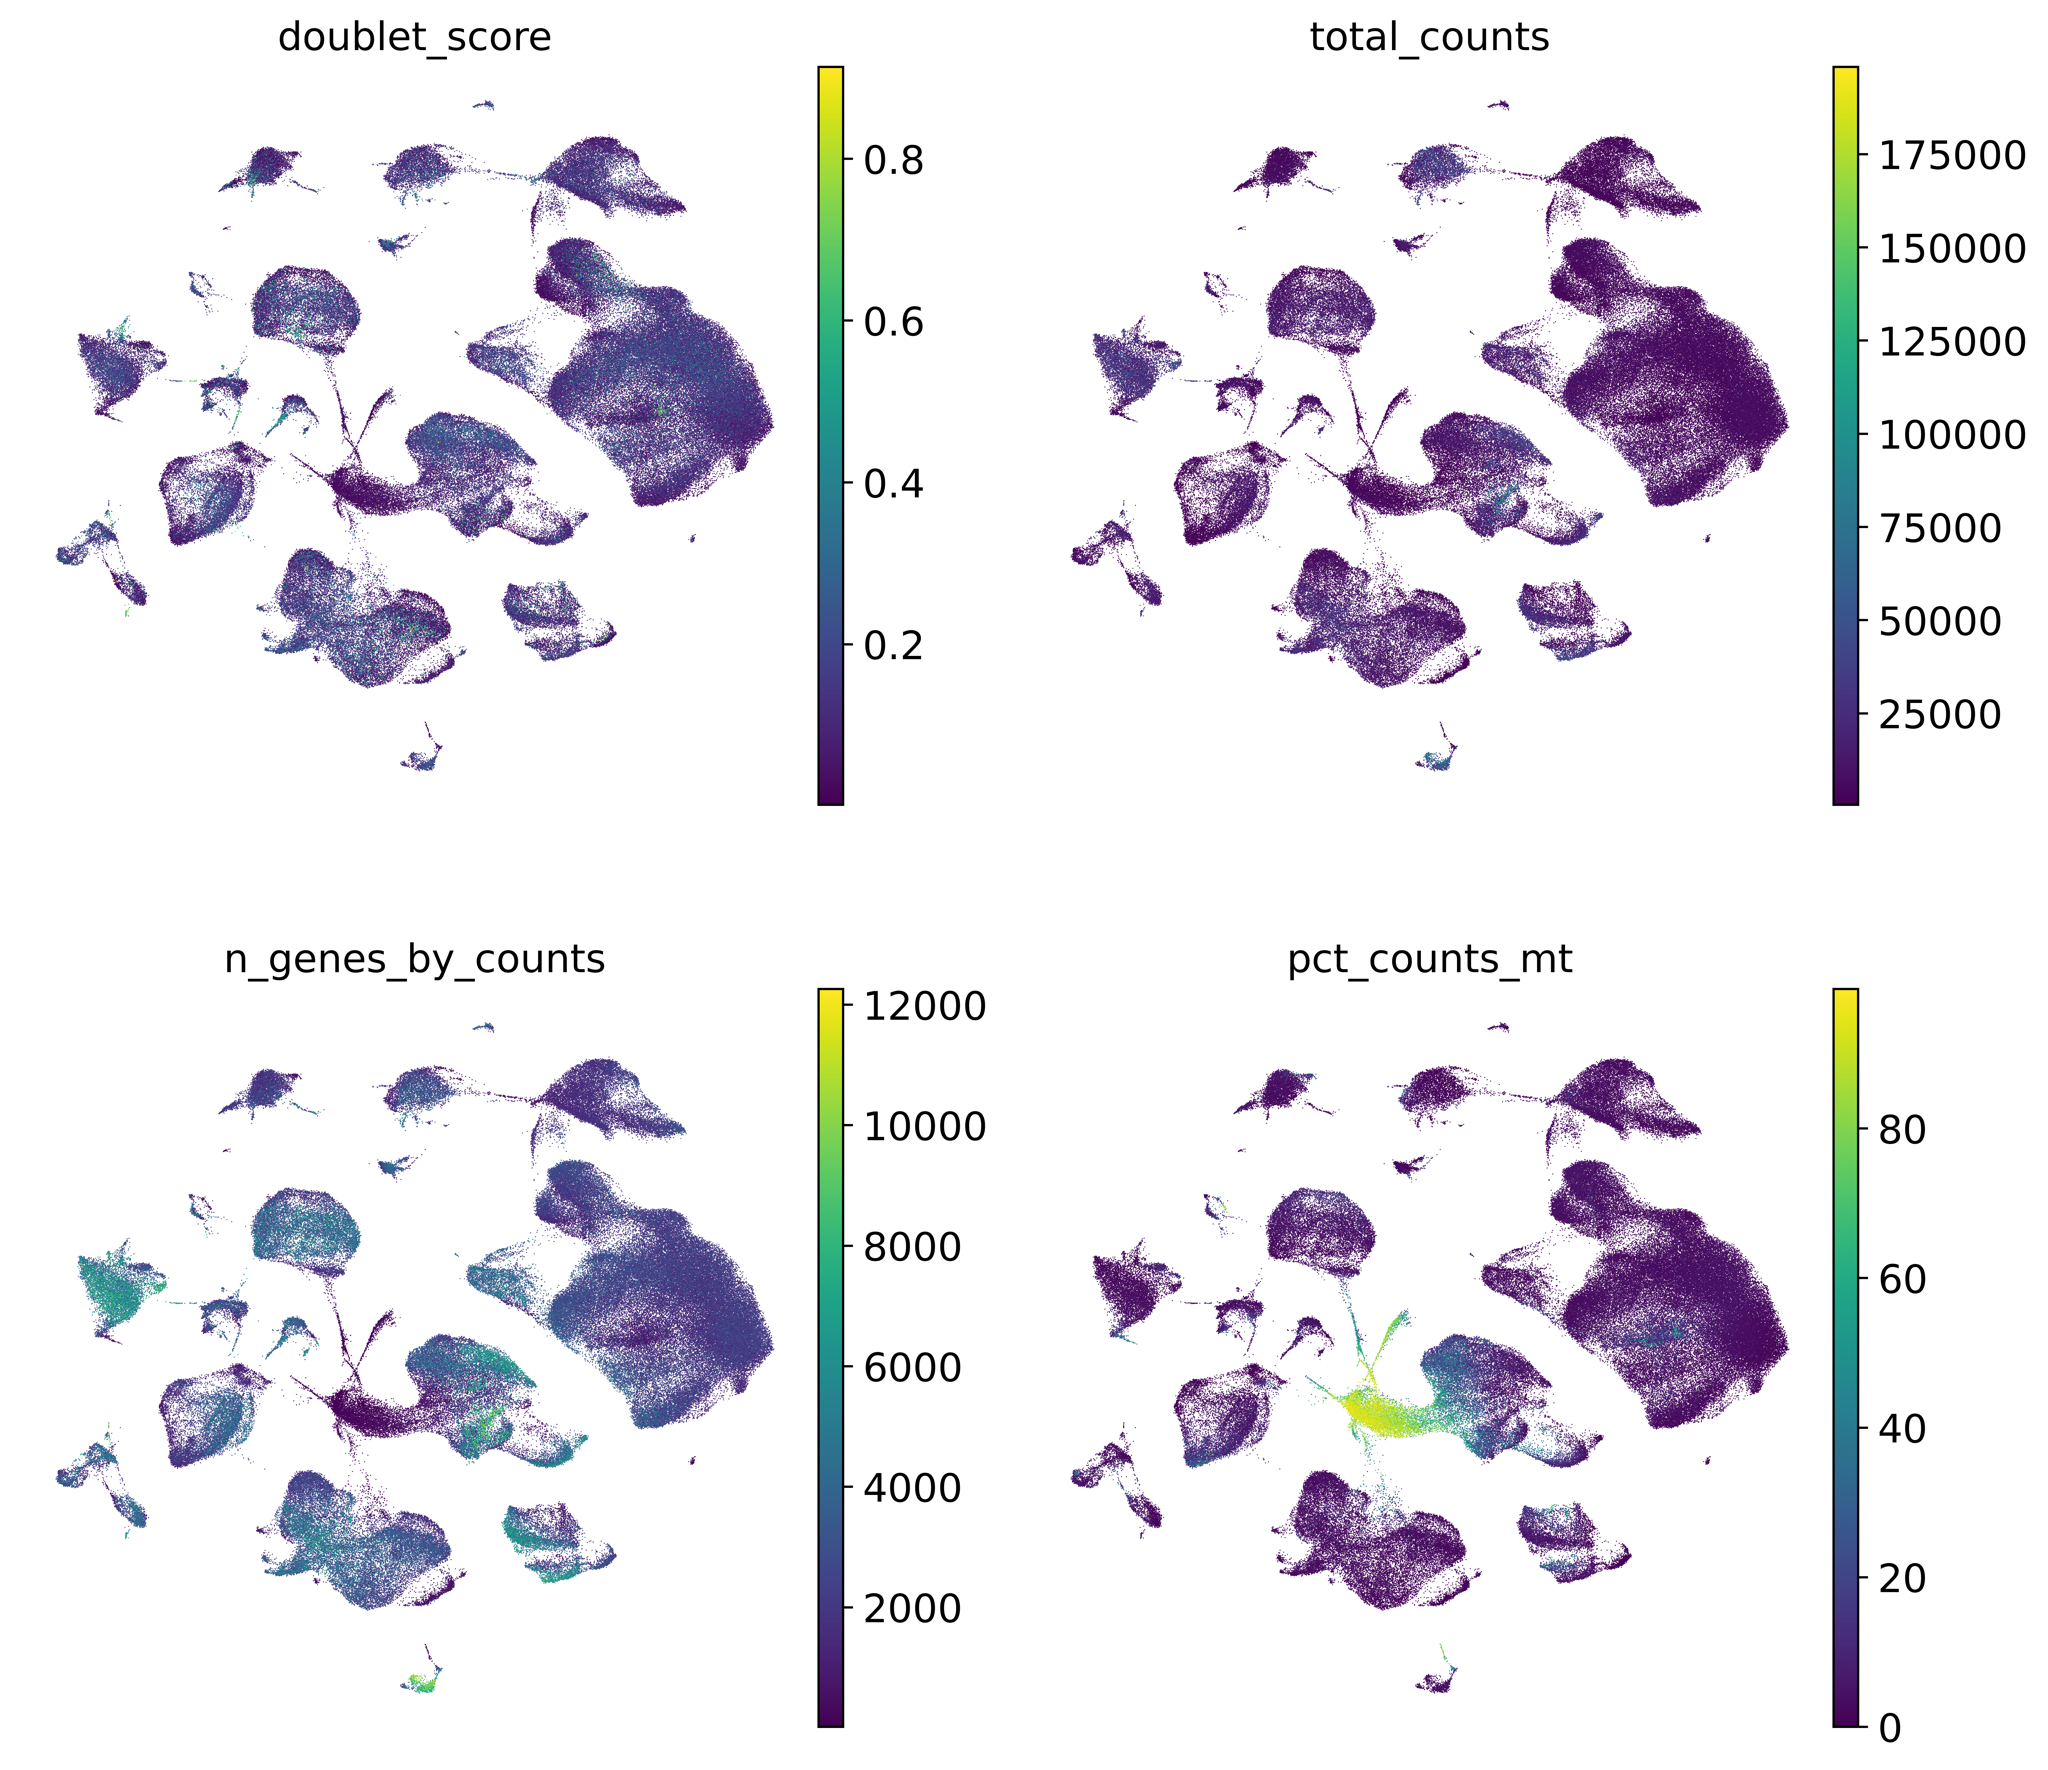

In [85]:
sc.settings.set_figure_params(dpi=400, dpi_save=500, figsize=(5,5), facecolor='white')
sc.pl.umap(
    adata, 
    color=['doublet_score', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
    frameon=False, 
    legend_fontoutline=1, 
    legend_fontsize=9, 
    ncols=2,
    #title='',
    save='_qc.pdf'
)

In [80]:
adata.obs.columns

Index(['Subproject_CNAG', 'Replicate', 'Patient', 'bc', 'batch', 'DOB',
       'Tumor Type', 'Primary tumor', 'Histology', 'Microsatellite status',
       'Molecular profile', 'N pre lines', 'Previous therapies',
       'Metastases location', 'Cohort', 'Treatment', 'Biopsy pre-treat',
       'Biopsy pre-C2', 'Biopsy', 'BiopsyEOT', 'Best response',
       'doublet_score', 'predicted_doublet', 'n_genes_by_counts',
       'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'],
      dtype='object')

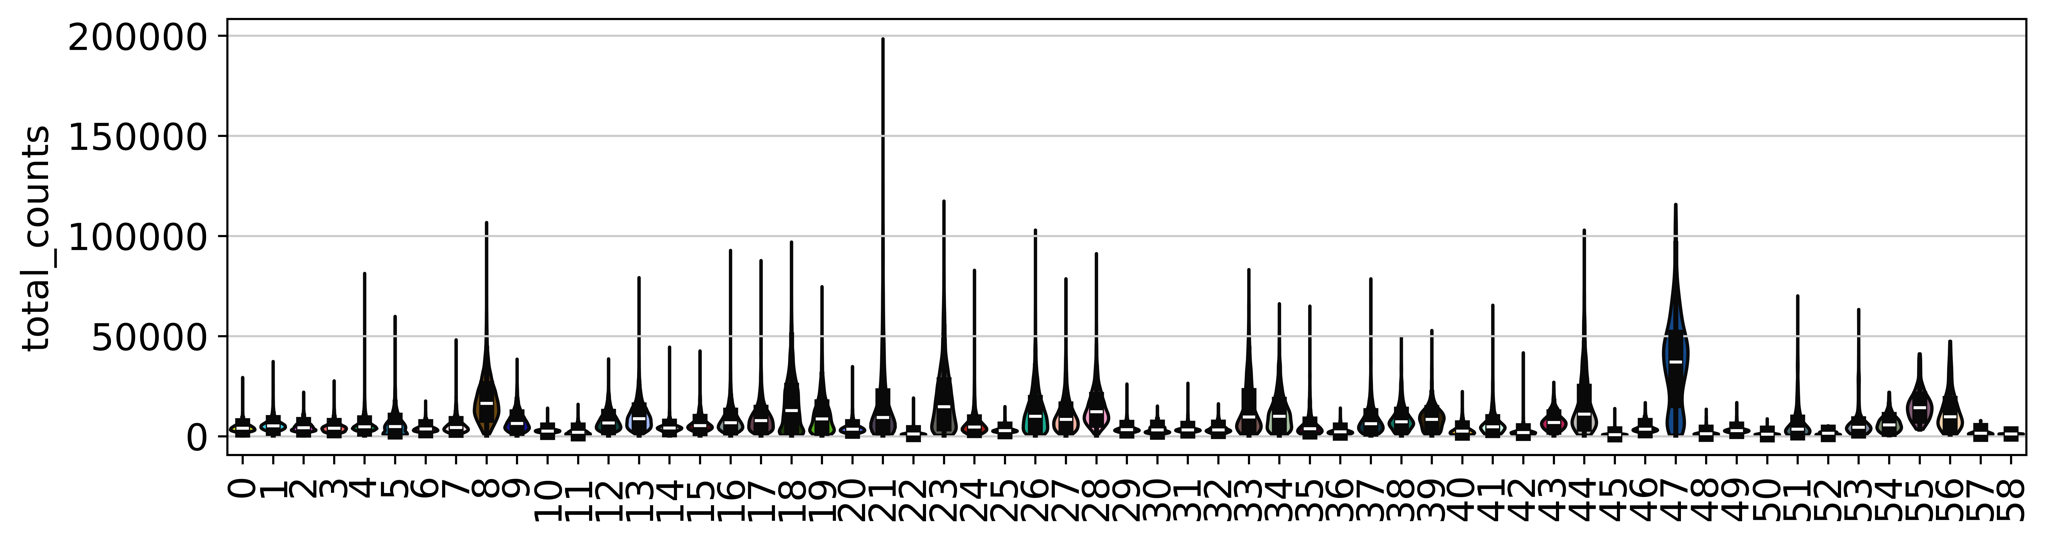

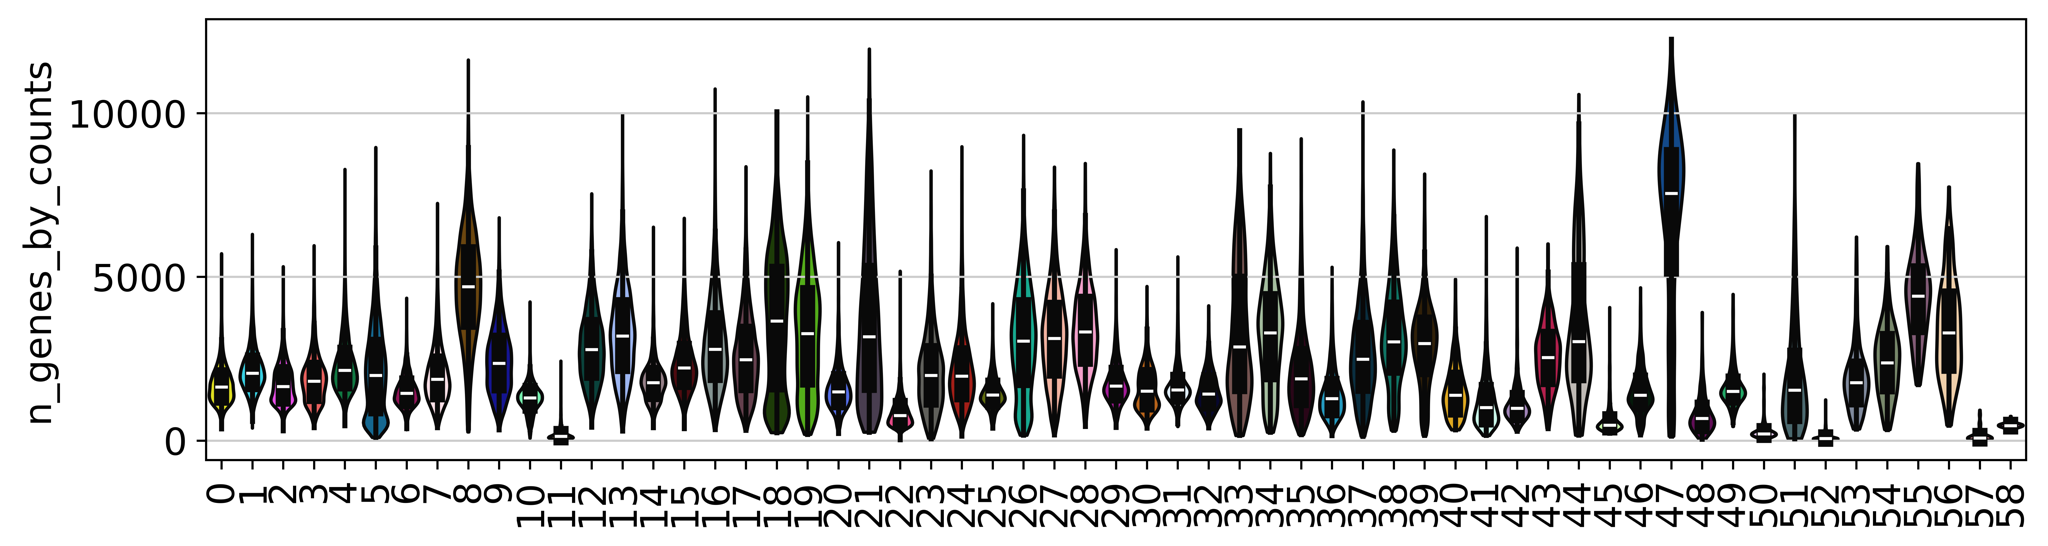

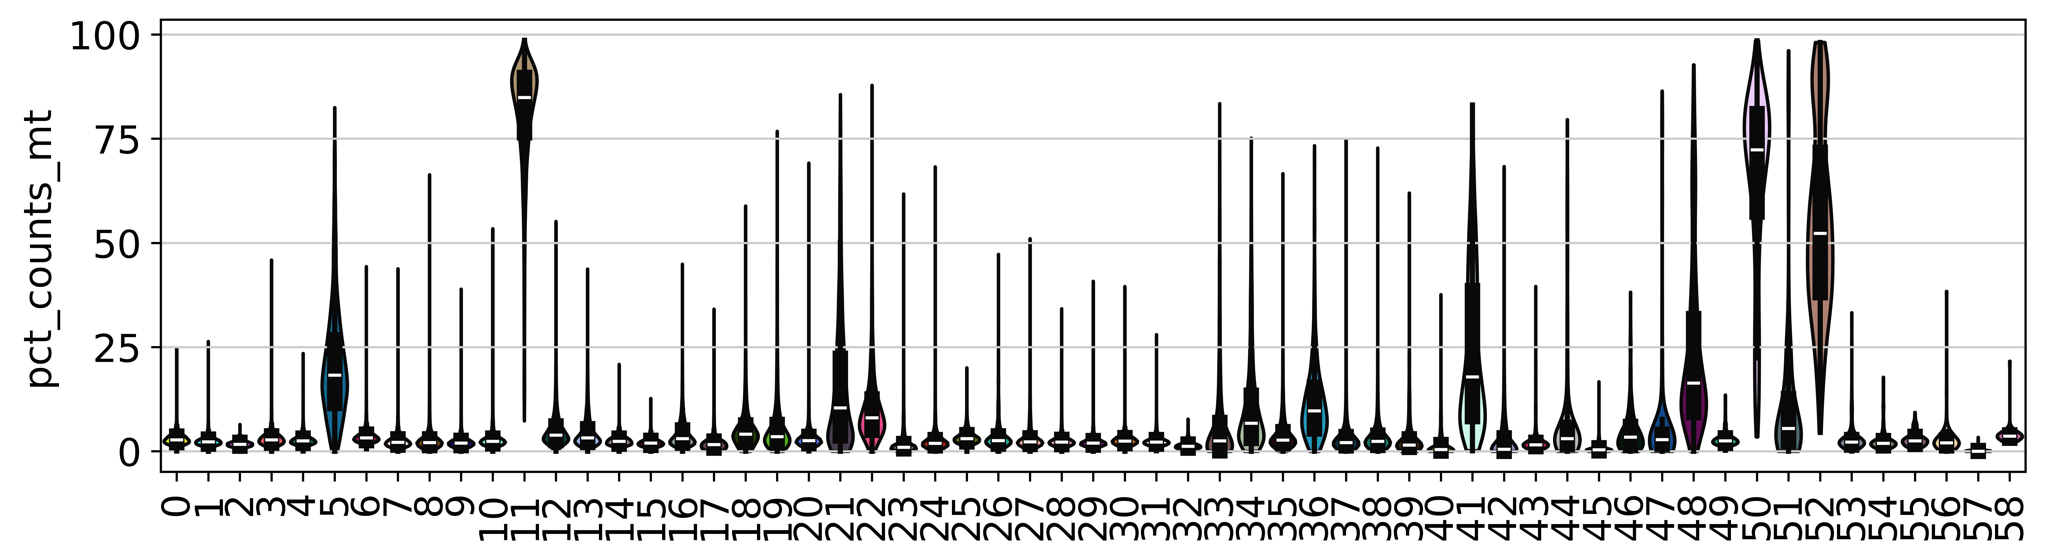

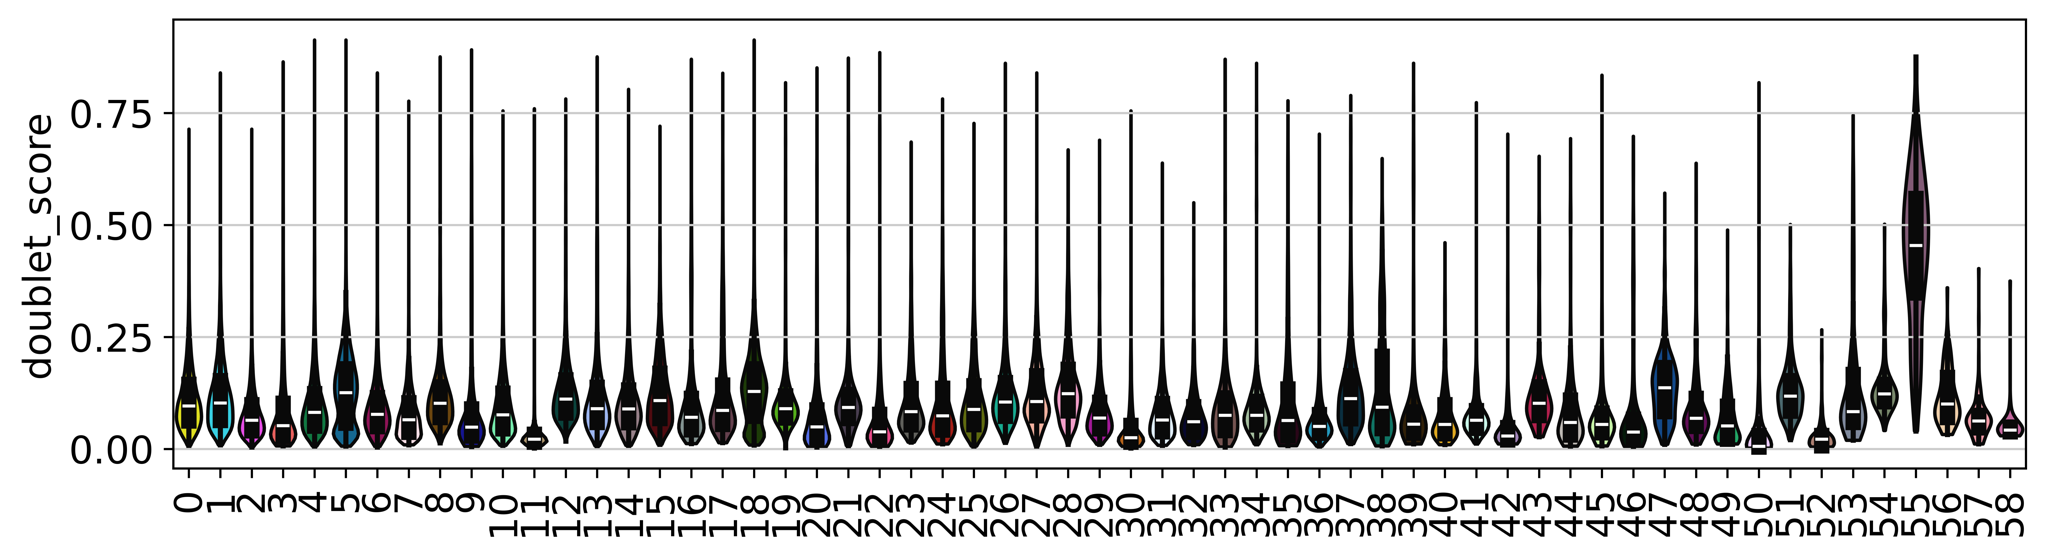

In [87]:
sc.settings.set_figure_params(dpi=400, dpi_save=400, figsize=(10,3), facecolor='white')
sc.pl.violin(adata,[ 'total_counts'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'n_genes_by_counts'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'pct_counts_mt'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'doublet_score'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=90)